# Business Objective

To help the average investor build a portfolio of stock and ensure maximum returns. Goals of the investor could range between short-term goals like saving for a dream vacation, down payment of a home etc. to long-term goals like saving for child's education, retirement etc.

The assumption here is that the investor already has an idea where they would like to invest. For ex: one investor might bet on an all electric future and hence is focused on electric car companies, battery manufacturers etc. Another investor, given recent events, might be looking at medical companies specializing in developing vaccines. EIther way, the aim here is to provide the investor a brief overview of the company performance, make predictions on future and try to provide an optimum investment portfolio. 

For the purpose of illustration, let work with someone betting on an all electric future. The companies we will be focussing on are **Tesla, General Motors and Ford.**

# Methodology

1. Data of the chosen stock from 2017-2022 will be scraped from [Yahoo Finance](https://finance.yahoo.com/)  using python's  `yfinance`(documentation can be found [here](https://aroussi.com/post/python-yahoo-finance)) and `YahooFinancials` (documentation can be found [here](https://pypi.org/project/yahoofinancials/)).

2. Using the data, 4 commonly used metrics to evaluate a stock will be plotted: ***returns, beta ratio, p/e ratio and dividend***

3. Different machine learning models will then be built to predict future stock price. Their errors will be compared and the model with the least error will be used gage future stock performance. 

4. Combined with stock performance and forecast information, then by feeding the chosen stock into the portfolio builder, the investor can look at combined returns and decide which portfolio is best-aligned with his/her goals.



# Collecting stock data 

In [1]:
#importing libraries

import yfinance as yf 
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import numpy as np
import pandas as pd
import itertools
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from scipy.signal._signaltools import _centered
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level='INFO')
mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

## Stock performance

Following is a function that will plot stock prices of a chosen stock from 2017 till date:

In [2]:
#function to get stock data of a company
start_date = '2017-01-01'
end_date = date.today()

def stock_info(ticker):
    #get stock prices for the specified date ranges
    df = yf.download(ticker,start=start_date,end=end_date)
    #plot the stock price over the years
    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(df['Adj Close']);
    ax.set_title(f'Stock Price of {ticker} from 2017 till date')

## Returns

Following is a function that plots returns from a chosen stock from 2017 till date:

In [3]:
#function to calculate stock return

def stock_return(ticker):
    #get stock prices for the specified date ranges
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_return['pct_change'] = df_return['Adj Close'].pct_change() # use pct change to calculate the diff 
    df_return.drop(df_return.index[0],inplace=True) # drop the Nan value from the first row
    
    #plot the returns over 5 years
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(df_return['pct_change']);
    ax.set_title('Stock Return Pct from 2017 till date:' +' ' + ticker)


## Beta value 

Beta value of a stock is used to signify risk i.e. if a stock is risky or not. By comparing the stock movement
relative to the overall market such as the S&P 500, the stock can be classified as risky or not. By definition, the market 
has a beta value of 1.0. If the beta value of the stock is greater than 1.0, then it is classified as risky and less so if the 
value is less than 1.0.

In [4]:
#function to calculate beta value of stock

def calculate_beta(ticker):
    
    #get data for ticker and SPY whih serves as the market index
    symbols = [ticker,'SPY']
    data = yf.download(symbols, start = start_date,end = end_date)['Adj Close']
    price_change = data.pct_change()
    price_change.drop(price_change.index[0],inplace=True)
    
    #reshape for linear regression
    X = np.array(price_change[ticker]).reshape((-1,1))
    y = np.array(price_change['SPY'])

    #create splits
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    #predictions
    y_preds = lr.predict(X_test)

    #plot 
    fig,ax = plt.subplots(figsize=(8,8));
    ax.plot(X_test,y_preds,linestyle=':',color='orange')
    ax.scatter(y_test,y_preds,alpha=0.5)
    ax.set_title(f' Beta value = {lr.coef_}')
    ax.set_xlabel('Market Index:SPY')
    ax.set_ylabel(f'{ticker} value')

## P/E ratio

Price-to-Earnings(P/E) ratio is a metric that compares a company's share price to it's earnings per share. It helps an investor
determine whether a stock is undervalued or overvalued. Hence, if a stock is overvalued, then the investor is paying more for the stock and betting on future growth and vice-versa.

In [5]:
#function to get historical PE ratios

def get_pe_ratio(ticker):
    
    #get financial statement of ticker using yahoofinancials
    financials = YahooFinancials(ticker)
    statement = financials.get_financial_stmts('annual', 'income', reformat=True)    
    
    #create a dict of the income statement alone
    dicts ={}
    for i in statement['incomeStatementHistory'][ticker]:
        dicts.update(i)
    
    #create a dataframe for easy use
    df = pd.DataFrame(dicts)
    df = df.T
    df['dilutedAverageShares'].fillna(df['dilutedAverageShares'].median(),inplace=True)
    
    #calculate pe ratio
    eps = df['netIncomeContinuousOperations']/df['dilutedAverageShares'] #calc earnings per share
    eps_df = pd.DataFrame(eps,index=df.index,columns=['EPS'])
    eps_df['PE ratio'] = financials.get_current_price()/eps_df['EPS']#get current price and calc pe ratio
    
    #plot result
    fig,ax=plt.subplots(figsize=(8,8));
    ax.plot(eps_df['PE ratio'],marker = '*', markerfacecolor = 'black')
    ax.set_title(f'Historical PE ratio: {ticker}')
    ax.set_ylabel('PE ratio')

## Dividend History

A Dividend is the distirbution's of the company's profit to it's shareholders. Not every company pays dividends. Companies can also choose to re-invest their profits for future growth than reward shareholders. For an investor, investing in a company that pays dividends is an easy way to earn extra income on top of their initial investment.

In [6]:
#function to get historical dividend data

def get_dividend(ticker):
    
    #get dividend data
    financials = YahooFinancials(ticker)
    div = financials.get_daily_dividend_data(start_date=start_date,end_date='2022-12-31')
    
    #check if the company pays dividends
    if div[ticker] == None:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.annotate(f'Sorry, {ticker} does not offer dividends',xy=(0.3,0.5),fontsize=20);
        ax.axis('off')
        return fig,ax
    
    else:#if company does pay dividends,then convert to a df and create a plot
        df = pd.DataFrame(div[ticker])
        df.drop('date',axis=1,inplace=True)
        df.rename(columns={'formatted_date':'date'},inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        fig,ax=plt.subplots(figsize=(8,8))
        ax.plot(df['amount']);
        ax.set_title(f'Dividend rate: {ticker}');

# Summing up performance...

In [7]:
def summary_info(ticker):
    return stock_info(ticker),stock_return(ticker),calculate_beta(ticker),get_pe_ratio(ticker),get_dividend(ticker)

By combining all of the above into one function called `summary_info`, the investor can get a cohesive of his/her chosen stock.
Below is an example od stock perfromance of **General Motors(tickr:'GM')**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


(None, None, None, None, None)

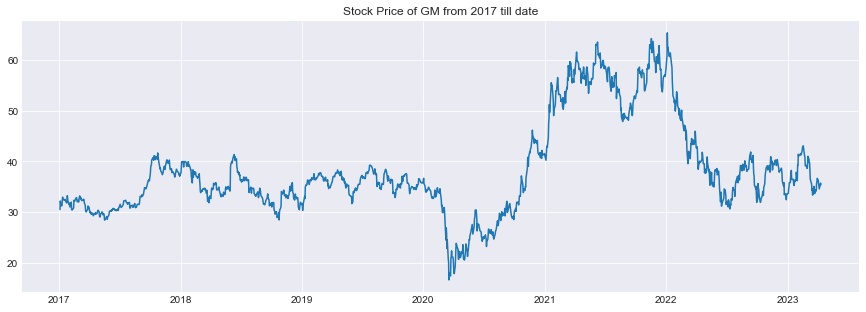

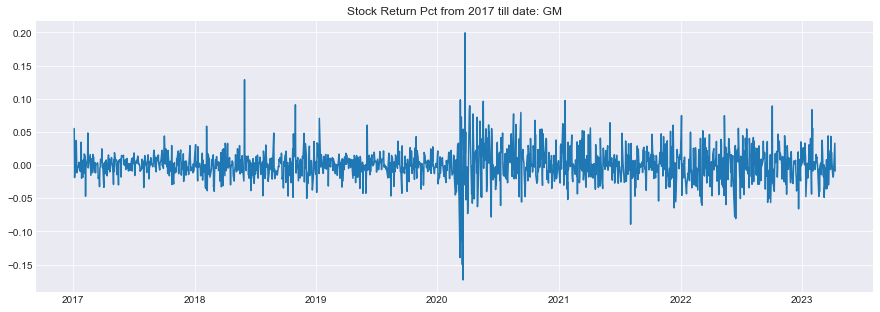

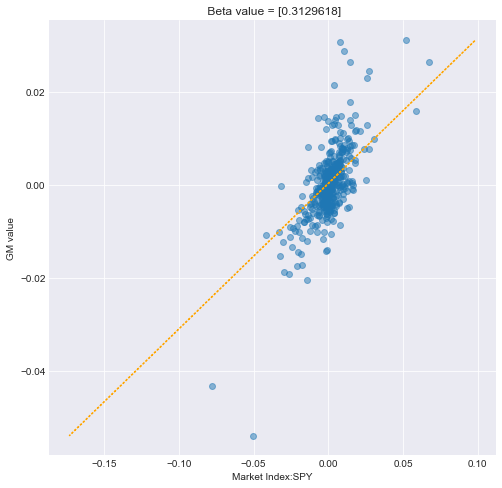

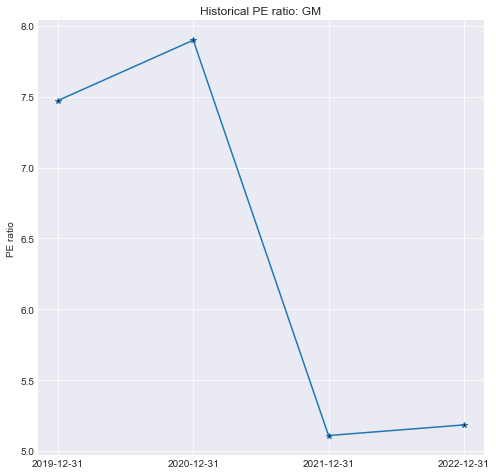

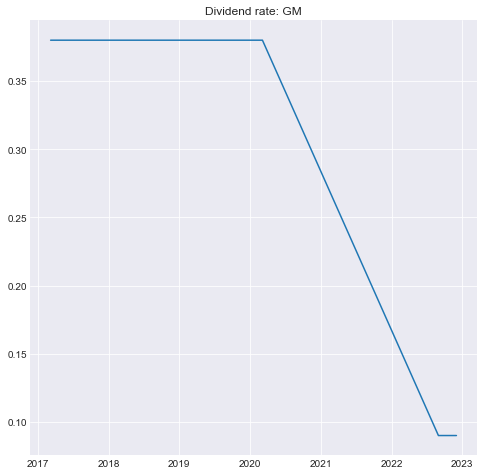

In [8]:
summary_info('GM')

# Time Series Modelling

Again, we will  use data of **GM** as an example. 

## Stationarity Check

Time series models are usually built on the premise that models are stationary i.e there are patters to the data and by analyzing these patterns, future performance can be predicted with a degree of certainity. However, this rarely happens in real life. There is always some trend or seasonality or a combination of both in the data.Hence the first step is to check for stationarity. 

The function below plots rolling-statistics and the ouptut of the Dickey-Fuller test

In [9]:
def plot_trends(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    close = df.loc[:,['Adj Close']]

#compute rolling mean and std to see if they are constant
    roll_mean = close.rolling(window=30,center=False).mean()
    roll_std = close.rolling(window=30,center=False).std()

#plot the data
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(close,color='blue',label='Original')
    ax.plot(roll_mean,color='red',label='Rolling Mean')
    ax.plot(roll_std,color='green',label='Rolling StdDev')
    ax.legend(loc='best')
    ax.set_title(f'Rolling Statistics of {ticker}');

#dickey Fuller Test
    dftest = adfuller(close['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])
    
    return dfoutput

[*********************100%***********************]  1 of 1 completed


,Values
Test Statistic,-1.948641
p-value,0.309536
#Lags Used,10.000000
Number of Observations Used,1567.000000


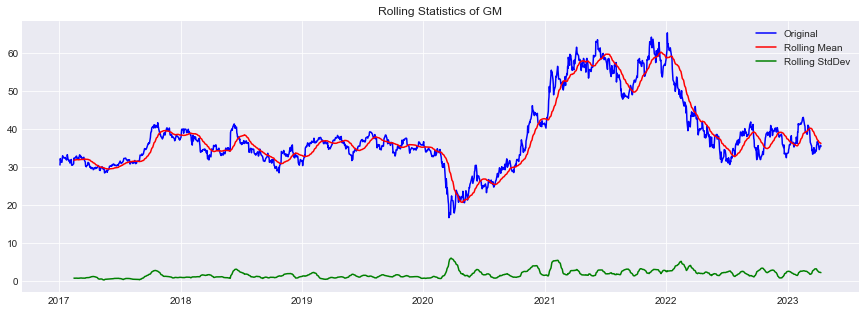

In [10]:
plot_trends('GM')

By computing the rolling mean we can see that there is an upward trend in the data. Since, the rolling stddev is fairly straight, we can conclude that there is not much seasonality in the data. Also shown is the results of the **Dickey-Fuller** test, a statistical method to check for stationarity. The large p-value points to a non-stationary dataset

## Convert non-stationary to stationary 

In [11]:
def differencing(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_diff =df_return.diff(periods=1)
    df_diff.dropna(inplace=True)
    
    #plot the results
    fig,ax = plt.subplots(figsize = (12,8));
    ax.plot(df_diff, label = 'Differenced');
    ax.plot(df_diff.rolling(30).mean(),label = 'Rolling Mean')
    ax.plot(df_diff.rolling(30).std(),label = 'Rolling StdDev')
    ax.set_title(f'Differenced plot of {ticker}')
    ax.legend(loc=2);
    
    #dickey fuller test
    dftest = adfuller(df_diff['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])
    
    return dfoutput

[*********************100%***********************]  1 of 1 completed


,Values
Test Statistic,-1.291722e+01
p-value,3.942703e-24
#Lags Used,9.000000e+00
Number of Observations Used,1.567000e+03


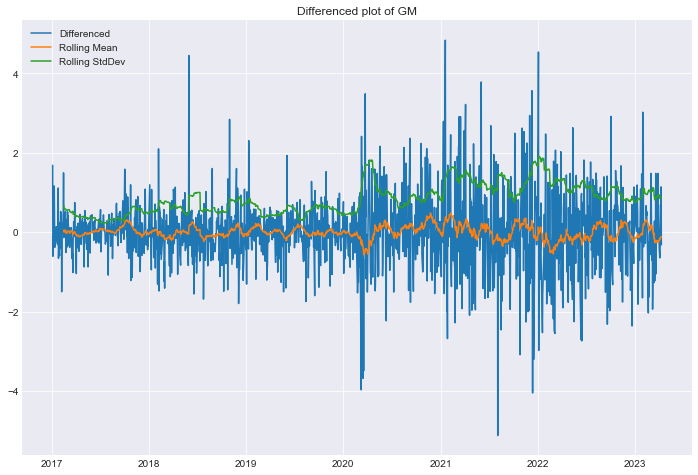

In [12]:
differencing('GM')

We can from the above plot that the mean though not perfectly flat is fairly linear signifying that we have removed the trend.
The miniscule p-value from the Dicley-Fuller test also points towards a stationary dataset

##  ACF and PACF

Since the ARIMA and SARIMA modelss are linear regression models, we need to decide on how many regression terms we will use for the model. The Auto-Correlation and Partial Auto Correlation plot(for the AR and MA models respectively) will show the number of lag terms that have the most effect on future price.

[*********************100%***********************]  1 of 1 completed


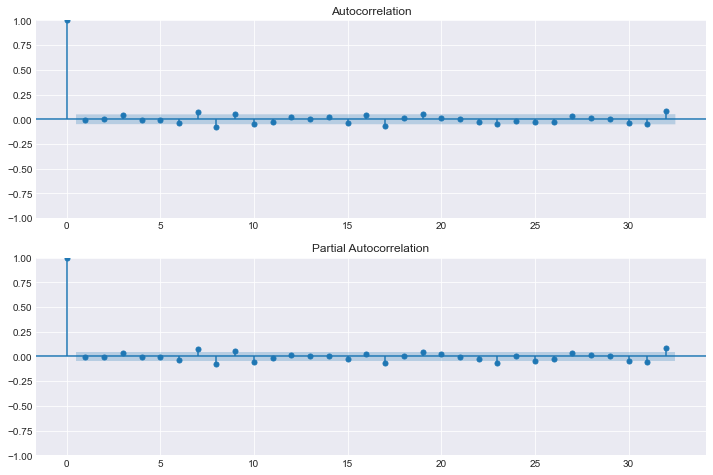

In [13]:
#get stock data
df = yf.download('GM',start=start_date,end=end_date)
df_close = df[['Adj Close']]
df_diff =df_close.diff(periods=1)
df_diff.dropna(inplace=True)

#plot ACF and PACF values
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,8))
acf = plot_acf(df_diff,ax=ax1)
pacf = plot_pacf(df_diff,ax=ax2)

From both the plots, we can see that the 1st lag term i.e the previous day's stock price, will have the most effect on the next day's price. There are other terms that have an effect as well, but for the sake of simplicity we will use only one term for the model.

## ARIMA model

We will first build and integrated AR and MA model known as ARIMA.

In [14]:
#defining train and test sets
cutoff= int(df_close.shape[0]*0.75)
train = df_close[:cutoff]
test = df_close[cutoff:]

Parameters for the model: **(p,d,q)=(1,1,1)** for the model based on the plots
1. p = number of terms for the AR model
2. d = order of differencing
3. q = numer of the terms for the MA model

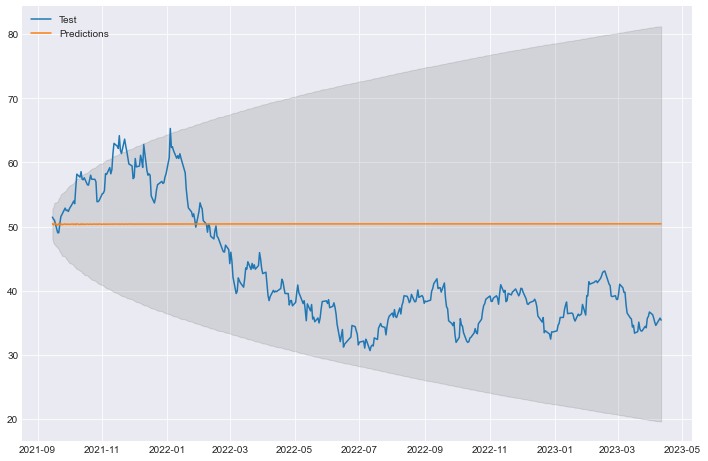

In [15]:
# (1,1,1) ARIMA(p,d,q) based on ACF and PACF plots
#instantiate
model = ARIMA(train,order=(3,1,3))

#fit
model_fit = model.fit()
# print(model_fit.summary())

#getting predictions using get_prediction method
arima_predictions = model_fit.get_prediction(start = len(train)+1 , end = len(df_close),dynamic=True)
#predicted_mean gives lists the values
arima_pred_price=arima_predictions.predicted_mean
#converting into a df
arima_pred_price_df = pd.DataFrame(data=arima_pred_price)
#seetting the index to the test dates
arima_pred_price_df.index= test.index

# arima_pred_price_df.head()

#confidence intervals of predictions
arima_conf_int = arima_predictions.conf_int()
arima_conf_int.set_index(test.index,inplace=True)

# arima_conf_int.head()

#plotting predictions with confidence intervals
fig,ax =plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train');
ax.plot(test,label='Test');
ax.plot(arima_pred_price_df,label='Predictions');
# ax.plot(arima_conf_int,label='Confidence Intervals')
ax.fill_between(arima_conf_int.index,arima_conf_int.iloc[:,0],arima_conf_int.iloc[:,1],color='k',alpha=0.1);
ax.legend(loc=2);

In [16]:
#RMSE
error_arima = round(np.sqrt(mean_squared_error(test,arima_pred_price_df)),2)
print(f'RMSE of the model is ${error_arima}')

RMSE of the model is $11.83


As we can tell, the model does not perform very well when compared to the test values

## SARIMA model

Next, we will build a SARIMA model. Like the ARIMA models, SARIMA model also depends on past values but has an extra seasonality component to take into account any seasonality patterns

the the p,d,q values from the ARIMA models as a guide, we can run different combinations to check for the most optimal paramenters. The model that outputs the lowest AIC score , will be used as our model

In [17]:
#defining a range for the p,d,q values
p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(train,
                          order=comb,
                          seasonal_order=combs,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('SARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

SARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=11943.657083199554
SARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=10330.234885577169
SARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=5778.384535345178
SARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=5731.176171688372
SARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=5783.755707957489
SARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=5781.516293612615
SARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=5735.456927857074
SARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=5716.500425249781
SARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=10332.829357294495
SARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=8793.069423238312
SARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=4712.538296502182
SARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=4649.067320459366
SARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=4722.031026869262
SARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=4690.289083614273
SARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=4658.72674

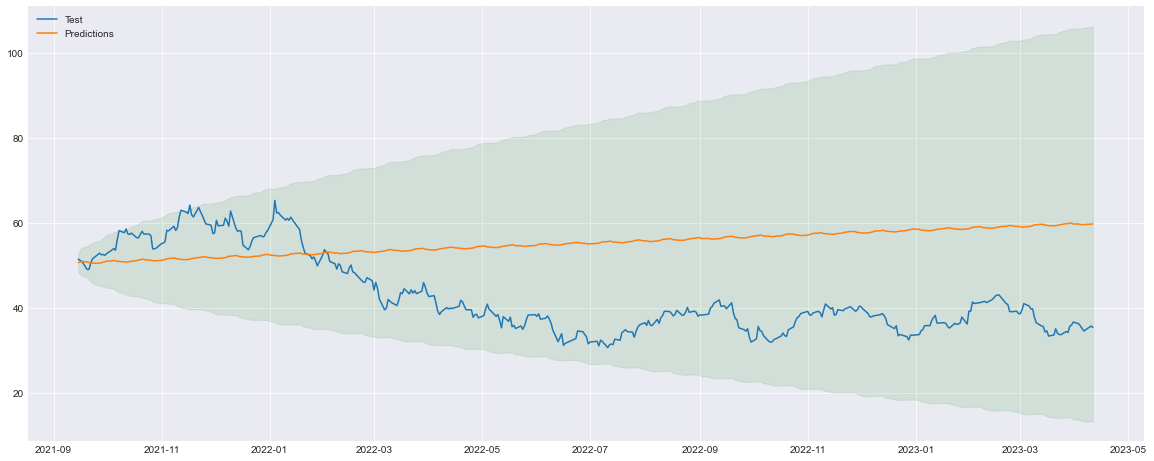

In [19]:
# Plug the optimal parameter values into a new SARIMAX model
sarimax = SARIMAX(train, 
                  order=(1,1,1), 
                  seasonal_order=(0 ,1, 1, 12), 
                  enforce_stationarity=False, 
                  enforce_invertibility=False)

# Fit the model and print results
output = sarimax.fit()

#get predictions
sarimax_predictions = output.get_prediction(start=len(train)+1,end=len(df_close),dynamic=True)
sarimax_price=sarimax_predictions.predicted_mean
sarimax_predictions_df = pd.DataFrame(data=sarimax_price)
sarimax_predictions_df.index= test.index

#get confidence intervals
sarimax_conf_int = sarimax_predictions.conf_int()
sarimax_conf_int.set_index(test.index,inplace=True)

#plot results
fig,ax =plt.subplots(figsize=(20,8))
# ax.plot(train,label='Train');
ax.plot(test,label='Test');
ax.plot(sarimax_predictions_df,label='Predictions');
# ax.plot(sarimax_conf_int,label='Confidence Intervals')
ax.fill_between(sarimax_conf_int.index,sarimax_conf_int.iloc[:,0],sarimax_conf_int.iloc[:,1],color='g',alpha=0.1);
ax.legend(loc=2);

In [20]:
#RMSE
error_sarima = round(np.sqrt(mean_squared_error(test,sarimax_predictions_df)),2)
print(f'RMSE of the model is ${error_sarima}')

RMSE of the model is $16.74


Compared to the ARIMA model, the SARIMA model performance is much worse.

## Facebook Prophet

The Prophet model is an additive model for time series predicting that was open sourced by Meta. in 2017.According to the official documentation, it works best with time series that have strong seasonal effects and several seasons of historical data  Prophet is robust to missing data and shifts in the trend and typically handles outliers well. 

First, we will use the default parameters and the undifferenced data to to build and evaluate the model:

[*********************100%***********************]  1 of 1 completed


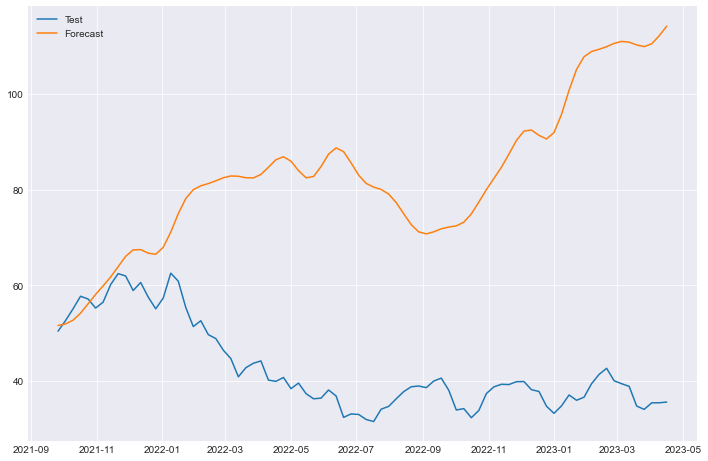

In [21]:
#get stock data
df = yf.download('GM',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

#setting up df to be able to run Prophet

#reset index
df_weekly.reset_index(inplace=True)

#rename columns per prophet conventions
df_weekly.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)

#set the date as the index
# df_close.set_index('ds',inplace=True)
# df_weekly.head()

#defining train and test sets
cutoff= int(df_weekly.shape[0]*0.75)
train = df_weekly[:cutoff]
test = df_weekly[cutoff:]

#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
           )

#fit
m.fit(train)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
test.set_index('ds',inplace=True)

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train')
ax.plot(test,label='Test')
# ax.plot(df_weekly,label='Current Price')
ax.plot(forecast_values['yhat'],label='Forecast')
# ax.fill_between(test.index,forecast_values['yhat_lower'],forecast_values['yhat_upper'],color='g',alpha=0.1);
ax.legend();



In [22]:
#RMSE
error_fb = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),2)
print(f'RMSE of the model is ${error_fb}')

RMSE of the model is $45.74


We can try to optimize the model by running a loop for the seasonality and changepoint values. These are deciding how much to penalize seasonality and changepoints changes in the data i.e if the values are small for the seasonality changes, then the effect of seasonal changes in the data is dampened and vice versa.

In [23]:
#run a loop for different regularization values

seasonality_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
changepoint_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
errors = []
new_error_fb = None

for season in seasonality_scale:
    for changepoint in changepoint_scale:
        #instantiate
        m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90,
                seasonality_prior_scale=season,
                changepoint_prior_scale=changepoint
               )

        #fit
        m.fit(train)
        
        #forecasts - creating future dates using in built make_future_dataframe method
        future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

        #predicting yhat 
        forecast = m.predict(future)

        #getting only yhat values
        forecast_values = forecast[['ds', 'yhat']]
        
        #setting the index
        forecast_values.set_index('ds',inplace=True)

        #rmse values
        rmse = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),3)
        errors.append(rmse)
        new_error_fb = min(errors)
        print(f'seasonality_scale:{season}, changepoint_scale:{changepoint}, rmse:{rmse}')
        
print('----------------------------------------------')
print(f'Smallest RMSE after looping is ${new_error_fb}')
print(f'Original RMSE is ${error_fb}')

seasonality_scale:0.1, changepoint_scale:0.1, rmse:49.503
seasonality_scale:0.1, changepoint_scale:0.2, rmse:47.291
seasonality_scale:0.1, changepoint_scale:0.3, rmse:46.434
seasonality_scale:0.1, changepoint_scale:0.4, rmse:45.572
seasonality_scale:0.1, changepoint_scale:0.5, rmse:44.929
seasonality_scale:0.2, changepoint_scale:0.1, rmse:47.307
seasonality_scale:0.2, changepoint_scale:0.2, rmse:45.824
seasonality_scale:0.2, changepoint_scale:0.3, rmse:44.466
seasonality_scale:0.2, changepoint_scale:0.4, rmse:43.891
seasonality_scale:0.2, changepoint_scale:0.5, rmse:43.624
seasonality_scale:0.3, changepoint_scale:0.1, rmse:46.611
seasonality_scale:0.3, changepoint_scale:0.2, rmse:44.815
seasonality_scale:0.3, changepoint_scale:0.3, rmse:43.747
seasonality_scale:0.3, changepoint_scale:0.4, rmse:43.615
seasonality_scale:0.3, changepoint_scale:0.5, rmse:42.924
seasonality_scale:0.4, changepoint_scale:0.1, rmse:45.88
seasonality_scale:0.4, changepoint_scale:0.2, rmse:44.351
seasonality_sca

We can see a decent jump in performance. Let's see if we can improve further

### Prophet with differencing - comparing with test

Like the other models, we can try and run the prophet model on stationary data to see if there is an improvement. We accomplish this by diffenreceing the data by an order of 1.

[*********************100%***********************]  1 of 1 completed


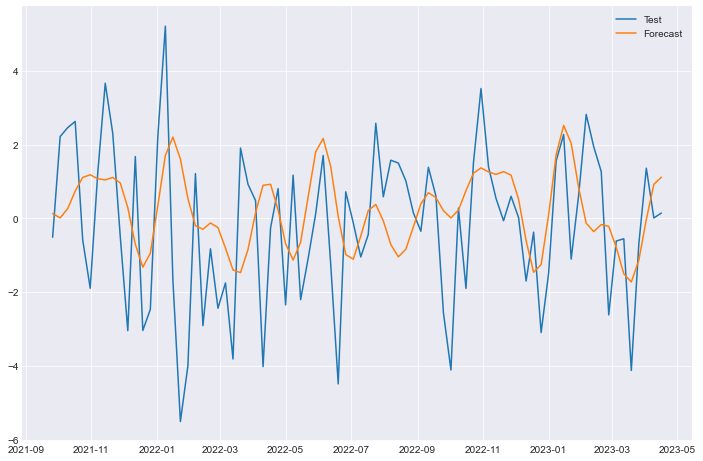

In [24]:
#get stock data
df = yf.download('GM',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

df_weekly = df_weekly.diff(periods=1)
df_weekly.dropna(inplace=True)

#setting up df to be able to run Prophet
#reset index
df_weekly.reset_index(inplace=True)
#rename columns per prophet conventions
df_weekly.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)

#defining train and test sets
cutoff= int(df_weekly.shape[0]*0.75)
train = df_weekly[:cutoff]
test = df_weekly[cutoff:]

#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
           )

#fit
m.fit(train)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat']]

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
test.set_index('ds',inplace=True)

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train')
ax.plot(test,label='Test')
# ax.plot(df_weekly,label='Current Price')
ax.plot(forecast_values['yhat'],label='Forecast')
# ax.fill_between(test.index,forecast_values['yhat_lower'],forecast_values['yhat_upper'],color='g',alpha=0.1);
ax.legend();


In [25]:
#RMSE
error_fb_diff = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),2)
print(f'RMSE of the model is ${error_fb_diff}')

RMSE of the model is $2.16


Here, we can see a vast improvement in model performance compared to before.

### regularization on differenced data

We will same optimization loop as earlier for the differenced data to see if it impacts performance.

In [26]:
#run a loop for different regularization values
seasonality_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
changepoint_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
errors = []
new_error_fb_diff = None

for season in seasonality_scale:
    for changepoint in changepoint_scale:
        #instantiate
        m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90,
                seasonality_prior_scale=season,
                changepoint_prior_scale=changepoint
               )

        #fit
        m.fit(train)
        
        #forecasts - creating future dates using in built make_future_dataframe method
        future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

        #predicting yhat 
        forecast = m.predict(future)

        #getting only yhat values
        forecast_values = forecast[['ds', 'yhat']]
        
        #setting the index
        forecast_values.set_index('ds',inplace=True)

        #rmse values
        rmse = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),3)
        errors.append(rmse)
        new_error_fb_diff = min(errors)
        print(f'seasonality_scale:{season}, changepoint_scale:{changepoint}, rmse:{rmse}')
        
print('----------------------------------------------')
print(f'Smallest RMSE after looping is {new_error_fb_diff}')
print(f'Original RMSE is {error_fb_diff}')

seasonality_scale:0.1, changepoint_scale:0.1, rmse:2.119
seasonality_scale:0.1, changepoint_scale:0.2, rmse:2.164
seasonality_scale:0.1, changepoint_scale:0.3, rmse:2.169
seasonality_scale:0.1, changepoint_scale:0.4, rmse:2.191
seasonality_scale:0.1, changepoint_scale:0.5, rmse:2.146
seasonality_scale:0.2, changepoint_scale:0.1, rmse:2.168
seasonality_scale:0.2, changepoint_scale:0.2, rmse:2.183
seasonality_scale:0.2, changepoint_scale:0.3, rmse:2.265
seasonality_scale:0.2, changepoint_scale:0.4, rmse:2.247
seasonality_scale:0.2, changepoint_scale:0.5, rmse:2.244
seasonality_scale:0.3, changepoint_scale:0.1, rmse:2.221
seasonality_scale:0.3, changepoint_scale:0.2, rmse:2.233
seasonality_scale:0.3, changepoint_scale:0.3, rmse:2.266
seasonality_scale:0.3, changepoint_scale:0.4, rmse:2.392
seasonality_scale:0.3, changepoint_scale:0.5, rmse:2.507
seasonality_scale:0.4, changepoint_scale:0.1, rmse:2.224
seasonality_scale:0.4, changepoint_scale:0.2, rmse:2.262
seasonality_scale:0.4, changepo

This time, the improvement is only slight. 

## Model performance comparisions

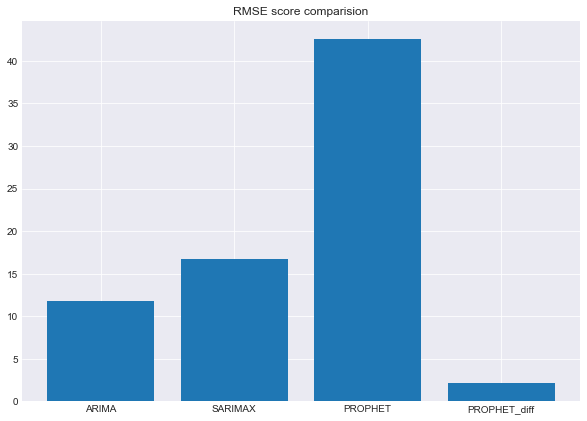

In [27]:
fig,ax =plt.subplots(figsize=(10,7))
ax.bar(x=['ARIMA', 'SARIMAX', 'PROPHET','PROPHET_diff'],height=[error_arima,error_sarima,new_error_fb,new_error_fb_diff]);
ax.set_title('RMSE score comparision');


From the plot, we can see the prohet model on the differenced data performs best. Hence, we will use that for making predictions for our chose stock.

## Using Prophet to get forecast of 'GM' for the next year

Now that we have a model, we can make predictions of the next year:

[*********************100%***********************]  1 of 1 completed


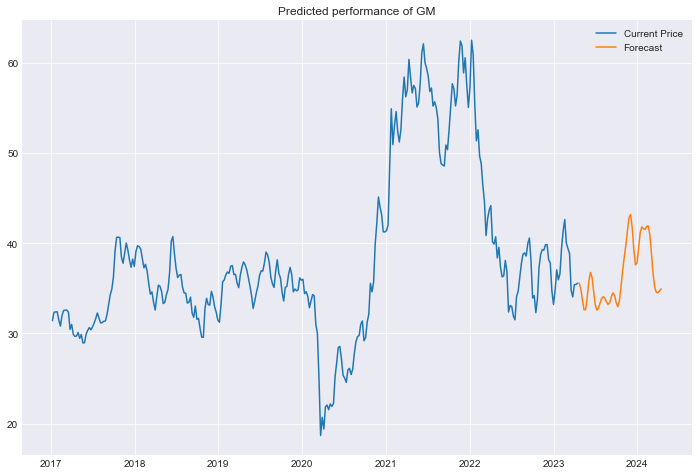

In [28]:
#get stock data
df = yf.download('GM',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

df_weekly_diff = df_weekly.diff(periods=1)
df_weekly_diff.dropna(inplace=True)


#setting up df to be able to run Prophet

#reset index
df_weekly_diff.reset_index(inplace=True)

#rename columns per prophet conventions
df_weekly_diff.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)


#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
            seasonality_prior_scale = 0.4,
            changepoint_prior_scale = 0.3
           )

#fit
m.fit(df_weekly_diff)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat']]

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
df_weekly_diff.set_index('ds',inplace=True)


#taking the inverse difference of the predicted values to get the original values
# the inverse diff is the cumsum of the first value of the org series & the first differences series
forecast_values.rename(columns={'yhat':'y'},inplace=True)
invdiff = np.r_[df_weekly['Adj Close'].iloc[-1],forecast_values['y'][1:]].cumsum()
invdiff_df = pd.DataFrame(data=invdiff,index = forecast_values.index,columns=['y'])

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(df_weekly,label='Current Price')
ax.plot(invdiff_df['y'],label='Forecast')
ax.set_title('Predicted performance of GM')
ax.legend();

The model predicts 'GM' to be to close to $35, no too far off from it's current value.

# Building Portfolio

## Predictions of chosen stock

Now that the investor has looked at some metrics and future performance of his/her chosen stock, he/she can now look
at building a portfolio for the future. Following are some functions that will be used in the portfolio builder

Following function is used to plot past and forecast prices of a stock:

In [29]:
def plot_forecast_price(ticker):
    #get stock data
    df = yf.download(ticker,start=start_date,end=end_date)
    df_close = df[['Adj Close']]

    #resmapling by weekly
    df_weekly = df_close.resample('W').mean()
    df_weekly_diff = df_weekly.diff(periods=1)
    df_weekly_diff.dropna(inplace=True)


    #setting up df to be able to run Prophet
    #reset index
    df_weekly_diff.reset_index(inplace=True)
    #rename columns per prophet conventions
    df_weekly_diff.rename(columns={'Adj Close': 'y',
                             'Date':'ds'},inplace=True)


    #instantiate
    m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90, 
                seasonality_prior_scale = 0.4,
                changepoint_prior_scale = 0.3
               )

    #fit
    m.fit(df_weekly_diff)

    #forecasts - creating future dates using in built make_future_dataframe method
    future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

    #predicting yhat 
    forecast = m.predict(future)

    #creating a df of predicted values
    forecast_values = forecast[['ds', 'yhat']]

    #set the index for the plots
    forecast_values.set_index('ds',inplace=True)
    df_weekly_diff.set_index('ds',inplace=True)


    #taking the inverse difference of the predicted values to get the original values
    # the inverse diff is the cumsum of the first value of the org series & the first differences series
    forecast_values.rename(columns={'yhat':'y'},inplace=True)
    invdiff = np.r_[df_weekly['Adj Close'].iloc[-1],forecast_values['y'][1:]].cumsum()
    invdiff_df = pd.DataFrame(data=invdiff,index = forecast_values.index,columns=['y'])

    #plotting results
    fig,ax=plt.subplots(figsize=(12,8))
    ax.plot(df_weekly,label='Current Price')
    ax.plot(invdiff_df['y'],label='Forecast')
    ax.set_title(f'Predicted values of {ticker}')
    ax.legend();

Following functions is to get the current price of a stock:

In [30]:
def get_current_price(ticker):
    df = yf.download(ticker,start=date.today())
    ticker_df = df[['Adj Close']]
    current_price = round(float(ticker_df.iloc[0]),2)
    
    return current_price

Following function is to get the last forecasted price of the stock:

In [31]:
def get_future_price(ticker):
     #get stock data
    df = yf.download(ticker,start=start_date,end=end_date)
    df_close = df[['Adj Close']]

    #resmapling by weekly
    df_weekly = df_close.resample('W').mean()
    df_weekly_diff = df_weekly.diff(periods=1)
    df_weekly_diff.dropna(inplace=True)


    #setting up df to be able to run Prophet
    #reset index
    df_weekly_diff.reset_index(inplace=True)
    #rename columns per prophet conventions
    df_weekly_diff.rename(columns={'Adj Close': 'y',
                             'Date':'ds'},inplace=True)


    #instantiate
    m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90, 
                seasonality_prior_scale = 0.4,
                changepoint_prior_scale = 0.3
               )

    #fit
    m.fit(df_weekly_diff)

    #forecasts - creating future dates using in built make_future_dataframe method
    future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

    #predicting yhat 
    forecast = m.predict(future)

    #creating a df of predicted values
    forecast_values = forecast[['ds', 'yhat']]

    #set the index for the plots
    forecast_values.set_index('ds',inplace=True)
    df_weekly_diff.set_index('ds',inplace=True)

    #taking the inverse difference of the predicted values to get the original values
    # the inverse diff is the cumsum of the first value of the org series & the first differences series
    forecast_values.rename(columns={'yhat':'y'},inplace=True)
    invdiff = np.r_[df_weekly['Adj Close'].iloc[-1],forecast_values['y'][1:]].cumsum()
    invdiff_df = pd.DataFrame(data=invdiff,index = forecast_values.index,columns=['y'])
    
    #get the last value
    last_price = round(float(invdiff_df.iloc[-1]),2)
    
    return last_price

The `portfolio` function combines all of the above and outputs the total returns

In [32]:
def portfolio(amount,stocks):
    stocks = stocks
    current_prices = []
    future_prices = []
    n_shares =[]
    return_pct = []

    amount = amount
    break_up = round(amount/len(stocks),2)

    for st in stocks:
        cp = get_current_price(st)
        fp = get_future_price(st)
    #     current_prices.append(get_current_price(st))
    #     future_prices.append(get_future_price(st))
        current_prices.append(cp)
        future_prices.append(fp)

        print(f'Current price of {st} is {cp}')
        print(f'Forecast price of {st} is {fp}')      

    # current_prices = np.array(current_prices)
    for i in current_prices:
        if break_up > i:
            share_buy = round(break_up/i)
            n_shares.append(share_buy)
        else:
            print(f'${break_up} per stock will not work since the cost of 1 share for one of the stocks is higher')

    n_shares = np.array(n_shares)
    future_prices = np.array(future_prices)

    sell_amounts = n_shares*future_prices
    returns = sell_amounts/break_up - 1
    invest_amt = round(break_up/amount,2)
    return_pct.append(returns*invest_amt)
    cum_returns = round(np.sum(return_pct) * 100,2)

    print('\n')
    print(f'Amount invested in each stock: ${break_up}')
    print(f'Cumulative returns: {cum_returns}%')
    

In [33]:
portfolio(1000,['TSLA','F','GM'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Current price of TSLA is 180.54
Forecast price of TSLA is 111.46
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Current price of F is 12.67
Forecast price of F is 14.99
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Current price of GM is 34.62
Forecast price of GM is 34.99


Amount invested in each stock: $333.33
Cumulative returns: -3.71%


Based on the output, the investor can expect to lose money if he/she were to invest $1000 in Tesla,GM and Ford in the next year.

## nested loops

In [133]:
stocks = ['AAPL','AMZN','NFLX']
amount = 800

current_prices = []
future_prices = np.array([])

for st in stocks:
    current_prices.append(get_current_price(st))
    future_prices = np.append(future_prices,get_future_price(st))
    
break_up = amount/len(stocks)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [134]:
current_prices

[160.1, 97.83, 331.03]

In [135]:
break_up

266.6666666666667

In [136]:
n_shares = np.array([])
return_pct = []
new = []
def check(): 
    for i in current_prices:
        if i < break_up:
               continue # there is nothing below continue to ignore. so nothing happens
# and continue moves the loop forward       
        else: # once the outer loop reaches the value of nflx and the condition is true,
#what is below is executed
            return ('Invest amount per stock is too low. Please adjust')
            break #breaks the inner loop
        break #this break is to ignore the outer loop as well as there is no point in moving forward
        
check()

if check() == None:
    print('yay')
else:
    print('nay')

# for i in current_prices:
#     if i > break_up:
#         print('Too little money')
#         break #first 2 i values are less than break_up. Hence, break is not activated and it
# # goes on to the else loop and you get screwed up.
# #what you want it to do is first check if all the i values are less than break_up. If that happens
# # then you can build the portfolio. if not raise an error and ask the investor to tweak.

#     else:
#         share_buy = round(break_up/i)
        
#         n_shares = np.append(n_shares,share_buy)

#         sell_amounts = n_shares*future_prices
#         returns = sell_amounts/break_up - 1
#         invest_amt = round(break_up/amount,2)
#         return_pct.append(returns*invest_amt)
#         cum_returns = round(np.sum(return_pct) * 100,2)

#         print('\n')
#         print(f'Amount invested in each stock: ${break_up}')
#         print(f'Cumulative returns: {cum_returns}%')
        


nay


In [87]:
# use the for-else syntax
for i in range(5):
    for j in range(5):
        print(i,j)
        if j == 2 and i == 0:
            break
    else:  # only execute when it's no break in the inner loop
        continue
        print('hi')#this will nver get printed since everyhting following the continue is ignored and
#it just goes to the next element in the outer loop.
    break

0 0
0 1
0 2


# Conclusions

## Limitations

1. All the models are purely mathematical models and cannot take into account black swan events.
2. More sophisticated models using Deep Learning can be built to get more accurate forecasts.
3. Dividend data is not incorporated while calculating overall returns.
4. Currently, all stocks in the portfolio are weighted equally when calculating returns. This can be improved by penalizing
   stocks that are more volatile and rewarding stock that are less volatile.

## Recommendations

Looking at the stock market in general, there was a drastic spike around 2020. There has not been a decline to pre-2020 levels and hence, it might be prudent to collect past data from 2020 onwards rather than from all the way back to 2017.

# LSTM

In [34]:
# from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM